In [11]:

!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git

dataset_path = "/content/Face-Mask-Detection/dataset/"
print("Dataset downloaded successfully.")


fatal: destination path 'Face-Mask-Detection' already exists and is not an empty directory.
Dataset downloaded successfully.


In [12]:
import os

print("Classes:", os.listdir(dataset_path))

with_mask_path = os.path.join(dataset_path, "with_mask")
without_mask_path = os.path.join(dataset_path, "without_mask")

print("Number of images with mask:", len(os.listdir(with_mask_path)))
print("Number of images without mask:", len(os.listdir(without_mask_path)))


Classes: ['with_mask', 'without_mask']
Number of images with mask: 2165
Number of images without mask: 1930


In [13]:
import os
import cv2
import numpy as np
import glob
import gc


dataset_path = "/content/Face-Mask-Detection/dataset/"

print("Classes:", os.listdir(dataset_path))


with_mask_path = os.path.join(dataset_path, "with_mask")
without_mask_path = os.path.join(dataset_path, "without_mask")

print("Number of images with mask:", len(os.listdir(with_mask_path)))
print("Number of images without mask:", len(os.listdir(without_mask_path)))


IMG_SIZE = (64, 64)

def load_images_from_folder(folder, label):
    images = []
    labels = []
    valid_extensions = ["png", "jpg", "jpeg"]

    for ext in valid_extensions:
        for filename in glob.glob(os.path.join(folder, f"*.{ext}")):
            img = cv2.imread(filename)
            if img is None:
                print(f"Skipping corrupted file: {filename}")
                continue

            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(label)

    return images, labels

images_with_mask, labels_with_mask = load_images_from_folder(with_mask_path, 1)  # 1 = With Mask
images_without_mask, labels_without_mask = load_images_from_folder(without_mask_path, 0)  # 0 = Without Mask

X = np.array(images_with_mask + images_without_mask, dtype=np.uint8)
y = np.array(labels_with_mask + labels_without_mask, dtype=np.uint8)

gc.collect()
print("Dataset loaded successfully.")
print(f"Total Images: {len(X)}, Labels: {len(y)}")


Classes: ['with_mask', 'without_mask']
Number of images with mask: 2165
Number of images without mask: 1930
Dataset loaded successfully.
Total Images: 4086, Labels: 4086


In [14]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


sift = cv2.SIFT_create()


def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list

sift_descriptors = extract_sift_features(X)

all_descriptors = np.vstack(sift_descriptors)

num_clusters = 50

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(all_descriptors)

def compute_bovw_histogram(descriptors, kmeans_model, num_clusters):
    histogram = np.zeros(num_clusters)
    if descriptors is not None:
        labels = kmeans_model.predict(descriptors)
        for label in labels:
            histogram[label] += 1
    return histogram

X_sift = np.array([compute_bovw_histogram(desc, kmeans, num_clusters) for desc in sift_descriptors])

scaler_sift = StandardScaler()
X_sift = scaler_sift.fit_transform(X_sift)

print("SIFT + BoVW feature extraction complete. Feature shape:", X_sift.shape)


SIFT + BoVW feature extraction complete. Feature shape: (4086, 50)


In [15]:
from skimage.feature import hog

def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm="L2-Hys")
        hog_features.append(features)
    return np.array(hog_features)


X_hog = extract_hog_features(X)


scaler_hog = StandardScaler()
X_hog = scaler_hog.fit_transform(X_hog)

print("HOG feature extraction complete. Feature shape:", X_hog.shape)


HOG feature extraction complete. Feature shape: (4086, 1764)


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_sift_features = X_sift  # If using SIFT-BoVW
X_hog_features = X_hog    # If using HOG

# Train & Evaluate SIFT Features
X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(X_sift_features, y, test_size=0.2, random_state=42)

svm_model_sift = SVC(kernel="linear")
svm_model_sift.fit(X_train_sift, y_train_sift)
svm_pred_sift = svm_model_sift.predict(X_test_sift)

logistic_model_sift = LogisticRegression()
logistic_model_sift.fit(X_train_sift, y_train_sift)
logistic_pred_sift = logistic_model_sift.predict(X_test_sift)

svm_acc_sift = accuracy_score(y_test_sift, svm_pred_sift)
logistic_acc_sift = accuracy_score(y_test_sift, logistic_pred_sift)

# Train & Evaluate HOG Features
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog_features, y, test_size=0.2, random_state=42)

svm_model_hog = SVC(kernel="linear")
svm_model_hog.fit(X_train_hog, y_train_hog)
svm_pred_hog = svm_model_hog.predict(X_test_hog)

logistic_model_hog = LogisticRegression()
logistic_model_hog.fit(X_train_hog, y_train_hog)
logistic_pred_hog = logistic_model_hog.predict(X_test_hog)

svm_acc_hog = accuracy_score(y_test_hog, svm_pred_hog)
logistic_acc_hog = accuracy_score(y_test_hog, logistic_pred_hog)

# Print results
print(f"SIFT + SVM Accuracy: {svm_acc_sift:.4f}")
print(f"SIFT + Logistic Regression Accuracy: {logistic_acc_sift:.4f}")
print(f"HOG + SVM Accuracy: {svm_acc_hog:.4f}")
print(f"HOG + Logistic Regression Accuracy: {logistic_acc_hog:.4f}")


SIFT + SVM Accuracy: 0.7127
SIFT + Logistic Regression Accuracy: 0.7115
HOG + SVM Accuracy: 0.8594
HOG + Logistic Regression Accuracy: 0.8643


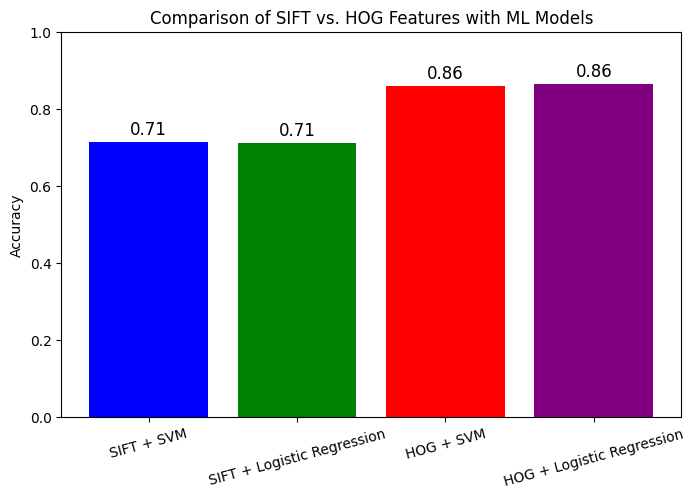

In [17]:
import matplotlib.pyplot as plt


models = ["SIFT + SVM", "SIFT + Logistic Regression", "HOG + SVM", "HOG + Logistic Regression"]
accuracies = [svm_acc_sift, logistic_acc_sift, svm_acc_hog, logistic_acc_hog]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=["blue", "green", "red", "purple"])
plt.ylabel("Accuracy")
plt.title("Comparison of SIFT vs. HOG Features with ML Models")
plt.ylim(0, 1)
plt.xticks(rotation=15)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=12)

plt.show()


In [18]:
print("Model Performance Comparison:")
print(f"SIFT + SVM Accuracy: {svm_acc_sift:.4f}")
print(f"SIFT + Logistic Regression Accuracy: {logistic_acc_sift:.4f}")
print(f"HOG + SVM Accuracy: {svm_acc_hog:.4f}")
print(f"HOG + Logistic Regression Accuracy: {logistic_acc_hog:.4f}")


Model Performance Comparison:
SIFT + SVM Accuracy: 0.7127
SIFT + Logistic Regression Accuracy: 0.7115
HOG + SVM Accuracy: 0.8594
HOG + Logistic Regression Accuracy: 0.8643


In [19]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression on SIFT features
lr_sift = LogisticRegression(max_iter=1000)
lr_sift.fit(X_train_sift, y_train_sift)
lr_pred_sift = lr_sift.predict(X_test_sift)

# Logistic Regression on HOG features
lr_hog = LogisticRegression(max_iter=1000)
lr_hog.fit(X_train_hog, y_train_hog)
lr_pred_hog = lr_hog.predict(X_test_hog)


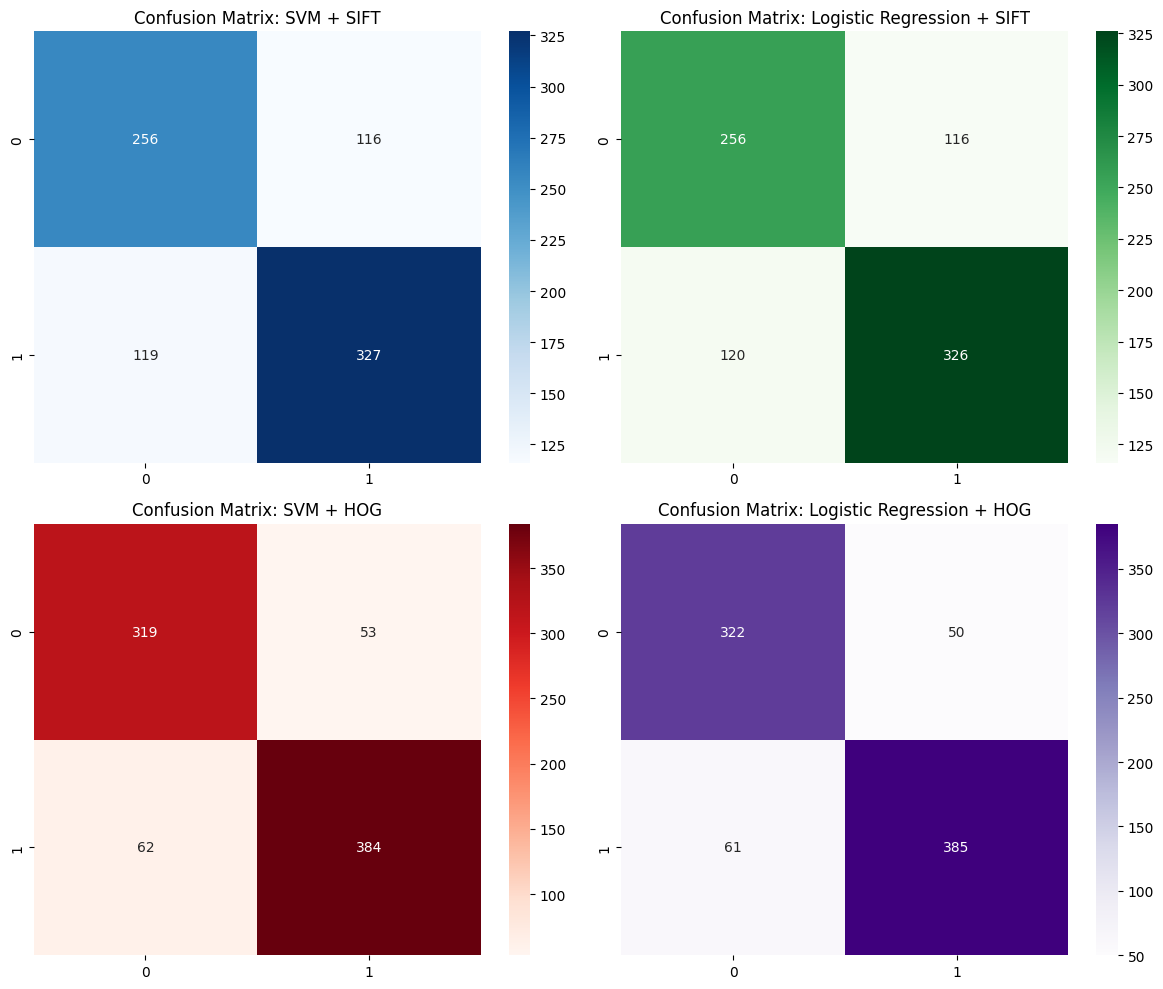

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Compute Confusion Matrices
cm_svm_sift = confusion_matrix(y_test_sift, svm_pred_sift)
cm_lr_sift = confusion_matrix(y_test_sift, lr_pred_sift)
cm_svm_hog = confusion_matrix(y_test_hog, svm_pred_hog)
cm_lr_hog = confusion_matrix(y_test_hog, lr_pred_hog)

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(cm_svm_sift, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix: SVM + SIFT")

sns.heatmap(cm_lr_sift, annot=True, fmt="d", cmap="Greens", ax=axes[0, 1])
axes[0, 1].set_title("Confusion Matrix: Logistic Regression + SIFT")

sns.heatmap(cm_svm_hog, annot=True, fmt="d", cmap="Reds", ax=axes[1, 0])
axes[1, 0].set_title("Confusion Matrix: SVM + HOG")

sns.heatmap(cm_lr_hog, annot=True, fmt="d", cmap="Purples", ax=axes[1, 1])
axes[1, 1].set_title("Confusion Matrix: Logistic Regression + HOG")

plt.tight_layout()
plt.show()


In [36]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:

# Load and preprocess dataset
data_dir = "/content/Face-Mask-Detection/dataset"
categories = ["with_mask", "without_mask"]

data = []
IMG_SIZE = 100

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append([img, label])
        except:
            continue

random.shuffle(data)

X, y = [], []
for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X) / 255.0
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:

# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [39]:

# Hyperparameter grid with optimizer as lambda
param_grid = [
    {"lr": 0.001, "batch_size": 32, "optimizer": lambda: Adam(learning_rate=0.001)},
    {"lr": 0.0005, "batch_size": 32, "optimizer": lambda: Adam(learning_rate=0.0005)},
    {"lr": 0.001, "batch_size": 64, "optimizer": lambda: RMSprop(learning_rate=0.001)},
    {"lr": 0.01, "batch_size": 32, "optimizer": lambda: SGD(learning_rate=0.01)}
]

results = []

for i, params in enumerate(param_grid):
    print(f"\nRunning Experiment {i+1} with lr={params['lr']}, batch_size={params['batch_size']}, optimizer={params['optimizer']().__class__.__name__}")

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=params["optimizer"](), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(datagen.flow(X_train, y_train, batch_size=params["batch_size"]),
                        validation_data=(X_test, y_test),
                        epochs=10, verbose=1)

    score = model.evaluate(X_test, y_test, verbose=0)
    results.append((params, score[1], history.history))



Running Experiment 1 with lr=0.001, batch_size=32, optimizer=Adam
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.6657 - loss: 0.7735 - val_accuracy: 0.8938 - val_loss: 0.2992
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8751 - loss: 0.3252 - val_accuracy: 0.9084 - val_loss: 0.2644
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9083 - loss: 0.2797 - val_accuracy: 0.9170 - val_loss: 0.2226
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9293 - loss: 0.2219 - val_accuracy: 0.9170 - val_loss: 0.2319
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.9236 - loss: 0.2175 - val_accuracy: 0.9145 - val_loss: 0.2319
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9289 - loss: 0.2000 - val_accuracy: 0.9304 - val_loss: 0.2003
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9243 - loss: 0.1950 - val_accuracy: 0.9109 - val_loss: 0.2135
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9406 - loss: 0.1650 - val_accuracy: 

In [40]:
# Extract CNN accuracies
cnn_acc_1 = results[0][1]
cnn_acc_2 = results[1][1]
cnn_acc_3 = results[2][1]
cnn_acc_4 = results[3][1]

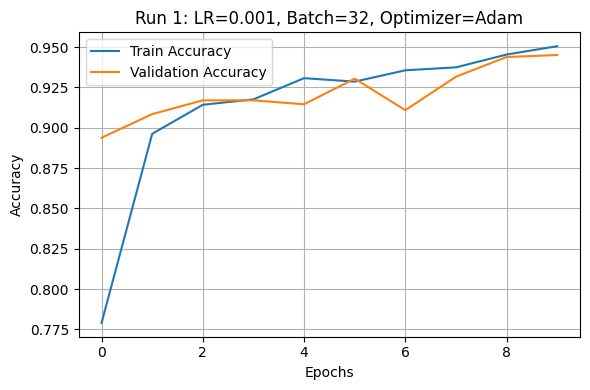

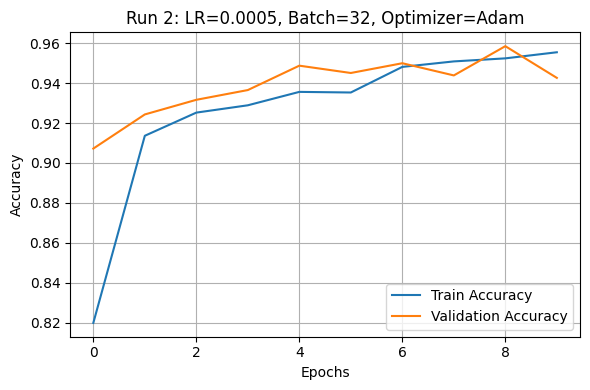

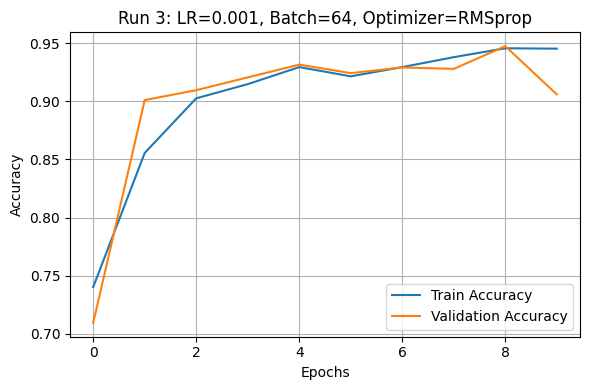

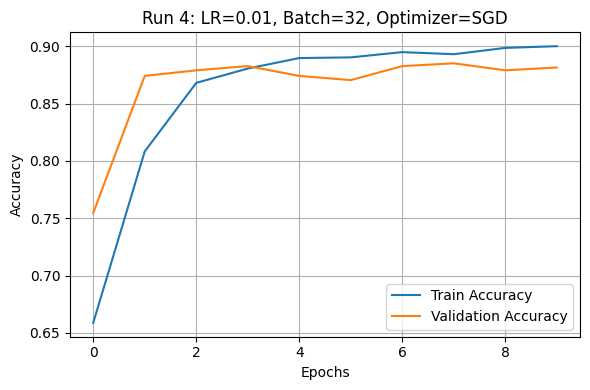

In [41]:

# Plot training & validation accuracy for each run
for i, (params, acc, hist) in enumerate(results):
    plt.figure(figsize=(6, 4))
    plt.plot(hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Run {i+1}: LR={params['lr']}, Batch={params['batch_size']}, Optimizer={params['optimizer']().__class__.__name__}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [42]:

# Create DataFrame to compare runs
comparison_df = pd.DataFrame({
    "Run": ["CNN Run 1", "CNN Run 2", "CNN Run 3", "CNN Run 4"],
    "Test Accuracy": [cnn_acc_1, cnn_acc_2, cnn_acc_3, cnn_acc_4]
})

print("CNN Accuracy Comparison:")
print(comparison_df)


CNN Accuracy Comparison:
         Run  Test Accuracy
0  CNN Run 1       0.945055
1  CNN Run 2       0.942613
2  CNN Run 3       0.905983
3  CNN Run 4       0.881563


In [43]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": [
        "SIFT + SVM",
        "SIFT + Logistic Regression",
        "HOG + SVM",
        "HOG + Logistic Regression",
        "CNN Run 1",
        "CNN Run 2",
        "CNN Run 3",
        "CNN Run 4"
    ],
    "Accuracy": [
        svm_acc_sift,
        logistic_acc_sift,
        svm_acc_hog,
        logistic_acc_hog,
        cnn_acc_1,
        cnn_acc_2,
        cnn_acc_3,
        cnn_acc_4
    ]
})

print(comparison_df)


                        Model  Accuracy
0                  SIFT + SVM  0.712714
1  SIFT + Logistic Regression  0.711491
2                   HOG + SVM  0.859413
3   HOG + Logistic Regression  0.864303
4                   CNN Run 1  0.945055
5                   CNN Run 2  0.942613
6                   CNN Run 3  0.905983
7                   CNN Run 4  0.881563


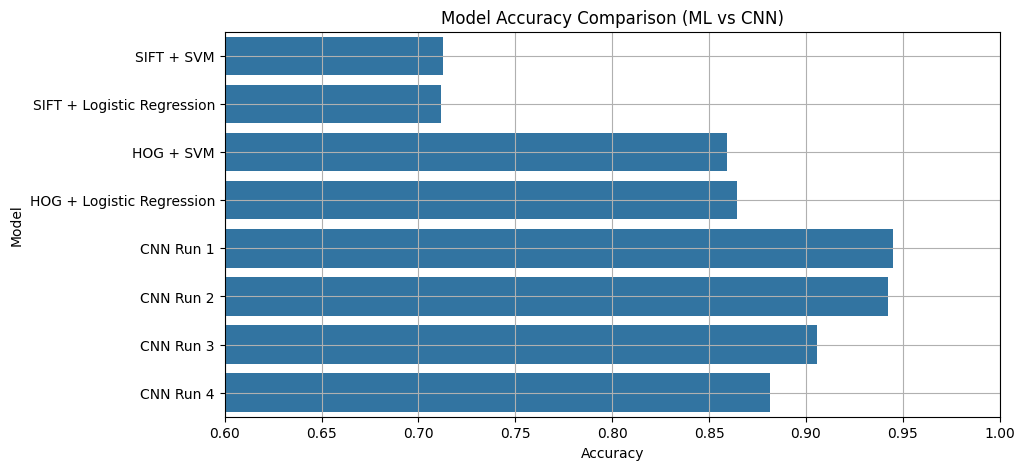

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(y="Model", x="Accuracy", data=comparison_df)
plt.title("Model Accuracy Comparison (ML vs CNN)")
plt.xlim(0.6, 1.0)
plt.grid(True)
plt.show()
